## Stock Performance Tracker


## Setup

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils, read_utils, draw_utils, process_utils, const

In [64]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")


## Read data


### Log table


In [65]:
log_df = read_utils.read_log()
# log_df.tail()


### Cashflow


In [66]:
cf_df = read_utils.read_cashflow(const.ACC_USER_DICT, const.ACC_COMBINED_NAME)
# # Drop specific users' columns
# cf_df = cf_df[const.ALL_ACC_NAME_L]
# cf_df.tail()


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


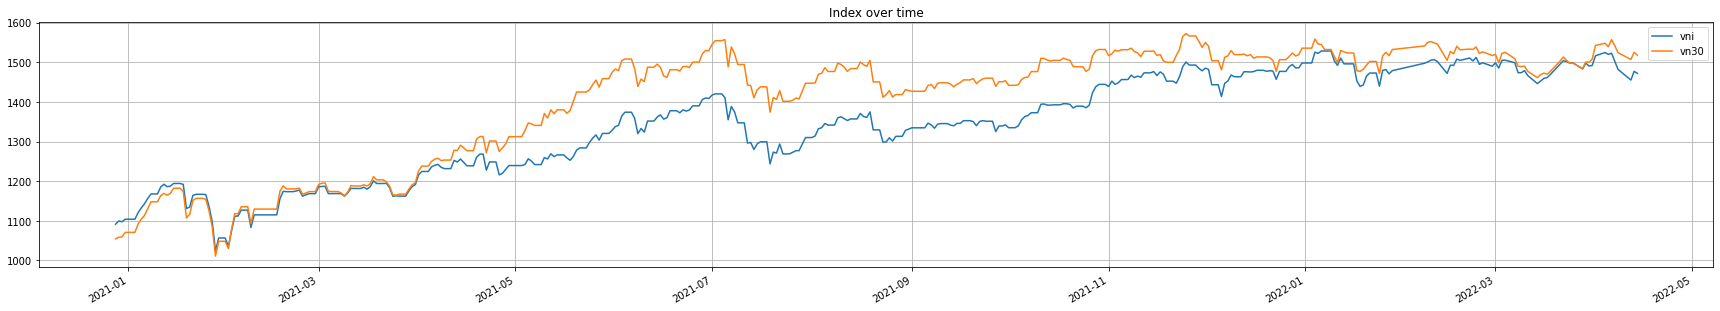

In [67]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in const.INDEX_NAME_L
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


## [Process] Processing


### Adding diff columns


In [68]:
log_df = process_utils.add_diff_column(log_df)
# log_df.tail()


### Remove unchanged dates from `log_df`


In [69]:
log_df = process_utils.remove_unchanged_rows(log_df)
# log_df.tail()

### Compensating diff with cashflow


In [70]:
log_df = process_utils.compensate_diff_with_cashflow(df=log_df, cashflow_df=cf_df, acc_name_l=const.ACC_NAME_L)
# log_df.tail()

### Adding Combined columns


In [71]:
# Add acc combined cols
log_df = process_utils.add_acc_combined_cols(
    log_df,
    acc_combined_name=const.ACC_COMBINED_NAME,
    acc_name_l=const.ACC_NAME_L,
)
# Add index combined cols
log_df = process_utils.add_index_combined_cols(
    log_df,
    index_combined_name=const.INDEX_COMBINED_NAME,
    index_name_l=const.INDEX_NAME_L,
)
# log_df.tail()


### Calculating diff percent & aux diff percent


In [72]:
log_df = process_utils.add_diff_percent(log_df, const.ALL_ACC_NAME_L, const.ALL_INDEX_NAME_L)
# log_df.tail()

## [Chart] NAV

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_89811/1060016281.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks() / 1_000_000))


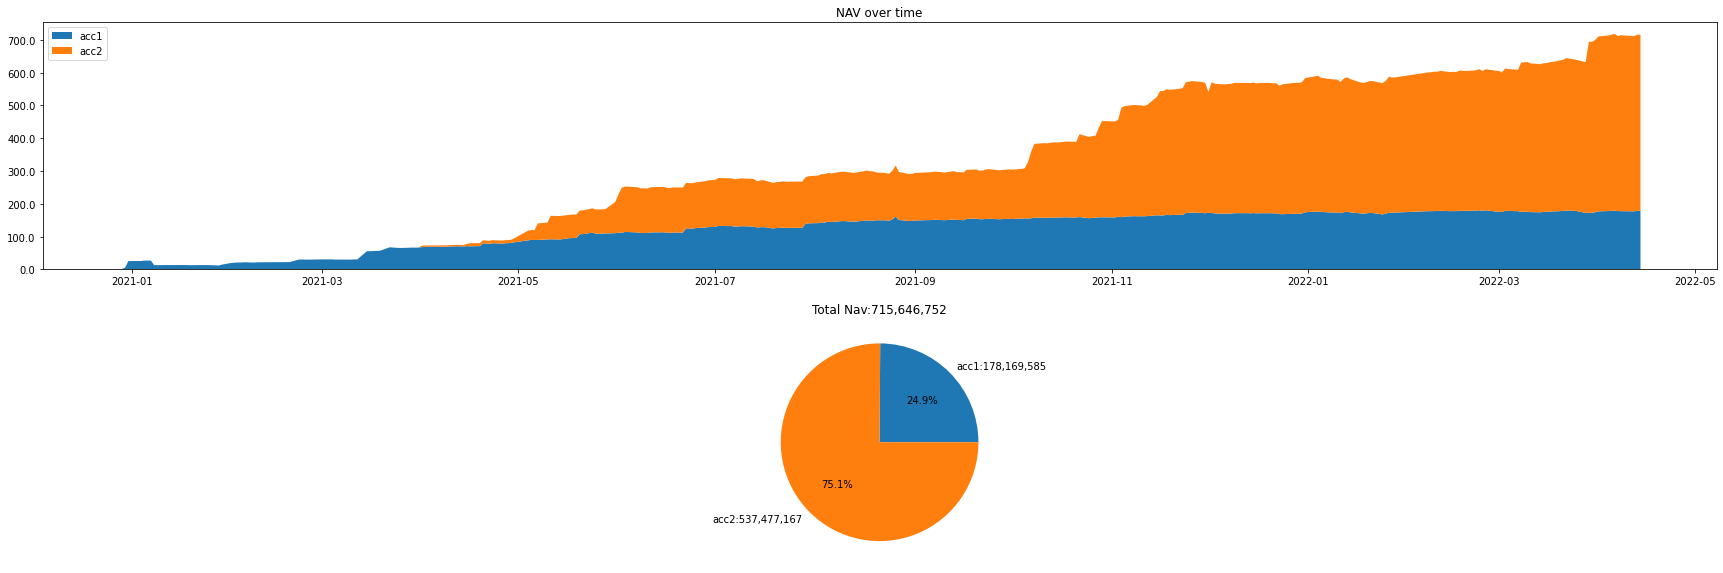

In [73]:
fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), nrows=2)  # type: ignore

# Line plot
y_list = [log_df[acc_name] for acc_name in const.ACC_NAME_L]
ax1.stackplot(log_df.index, y_list, labels=const.ACC_NAME_L)

# set labels to absolute values
ax1.set_yticklabels(abs(ax1.get_yticks() / 1_000_000))

ax1.set_title("NAV over time")
ax1.legend(loc="upper left")

# Pie chart
nav_l = [log_df[acc_name].iloc[-1] for acc_name in const.ACC_NAME_L]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(const.ACC_NAME_L, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")

plt.show()


## [Chart] Profit

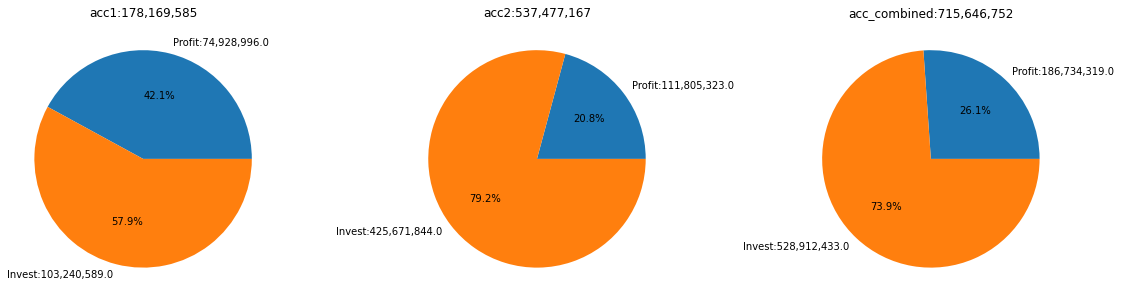

In [74]:
fig, ax_l = plt.subplots(figsize=(20, 5), ncols=3, facecolor="white")  # type: ignore

for name, ax in zip(const.ALL_ACC_NAME_L, ax_l):  # type: ignore
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest

    profit_label = f"Profit:{profit:,}"
    invest_label = f"Invest:{invest:,}"

    ax.pie([profit, invest], labels=[profit_label, invest_label], autopct="%1.1f%%")
    ax.set_title(f"{name}:{nav:,}")

plt.show()


## User Analysis

In [75]:
acc_name = 'acc1'
user_name_l = const.ACC_USER_DICT['acc1']

In [76]:
# Get data from log_df
acc_df = log_df[[acc_name, f"{acc_name}_diff"]]

# Get data from cashflow dataframe
acc_cf_df = cf_df[user_name_l]
acc_cf_df = acc_cf_df.rename(columns={user_name: f"{user_name}_cf" for user_name in user_name_l})

user_df = pd.concat([acc_df, acc_cf_df], axis=1)
user_df.fillna(0, inplace=True)

user_df["day_start_nav"] = user_df[acc_name] - user_df[f"{acc_name}_diff"]

# Delete rows with day_start_nav == 0 (the first row in this case)
user_df = user_df[user_df["day_start_nav"] != 0]

# 
day_start_user_nav_dict = {user_name: 0.0 for user_name in user_name_l}
for user_name in user_name_l:
    user_df[f"{user_name}_share"] = 0.0
for date in user_df.index:
    day_start_nav = user_df.loc[date, "day_start_nav"]
    # First, add yesterday's user nav with today cashflow
    for user_name in user_name_l:
        # Investment is saved as negative number in cashflow
        day_start_user_nav_dict[user_name] -= user_df.loc[date, f"{user_name}_cf"]

        # print(day_start_user_nav_dict)

        user_share = day_start_user_nav_dict[user_name] / day_start_nav
        user_df.loc[date, f"{user_name}_nav"] = day_start_user_nav_dict[user_name]
        user_df.loc[date, f"{user_name}_share"] = user_share
        user_df.loc[date, f"{user_name}_diff"] = user_df.loc[date, f"{acc_name}_diff"] * user_share

    
        

# Calculate share of user
# user_share_dict = {user_name: 0.0 for user_name in user_name_l}
# for date in user_df.index:
#     for user_name in user_name_l:
#         user_share_dict[user_name] += float(
#             -user_df.loc[date, user_name] / user_df.loc[date, "day_start_nav"]
#         )
#     sum_share = sum(user_share_dict.values())
#     for user_name in user_name_l:
#         user_share_dict[user_name] = user_share_dict[user_name] / sum_share
#         user_df.loc[date, f"{user_name}_share"] = user_share_dict[user_name]

# Calculate purchase share
# for user_name in user_name_l:
#     user_df[f'{user_name}_purchase_share'] = - user_df[user_name] / user_df[acc_name].shift()
# Cummulative investment
# for user_name in user_name_l:
#     user_df[f"{user_name}_cumsum"] = user_df[user_name].cumsum()
user_df


,acc1,acc1_diff,ta_cf,tn_cf,day_start_nav,ta_share,tn_share,ta_nav,ta_diff,tn_nav,tn_diff
date,,,,,,,,,,,
2020-12-29,998349,-1651.0,-1000000.0,0.0,1000000.0,1.000000,0.0,1000000.0,-1.651000e+03,0.0,-0.0
2020-12-30,4970862,-27487.0,-4000000.0,0.0,4998349.0,1.000330,0.0,5000000.0,-2.749608e+04,0.0,-0.0
2020-12-31,25049818,78956.0,-20000000.0,0.0,24970862.0,1.001167,0.0,25000000.0,7.904813e+04,0.0,0.0
2021-01-04,25319834,270016.0,0.0,0.0,25049818.0,0.998011,0.0,25000000.0,2.694790e+05,0.0,0.0
2021-01-05,26558841,139007.0,-1100000.0,0.0,26419834.0,0.987894,0.0,26100000.0,1.373242e+05,0.0,0.0
2021-01-06,26581996,23155.0,0.0,0.0,26558841.0,0.982724,0.0,26100000.0,2.275497e+04,0.0,0.0
2021-01-07,26594069,12073.0,0.0,0.0,26581996.0,0.981868,0.0,26100000.0,1.185409e+04,0.0,0.0
2021-01-08,12633806,39737.0,14000000.0,0.0,12594069.0,0.960770,0.0,12100000.0,3.817811e+04,0.0,0.0
2021-01-11,12829848,196042.0,0.0,0.0,12633806.0,0.957748,0.0,12100000.0,1.877588e+05,0.0,0.0


## [Chart] Diff percent


### Histogram

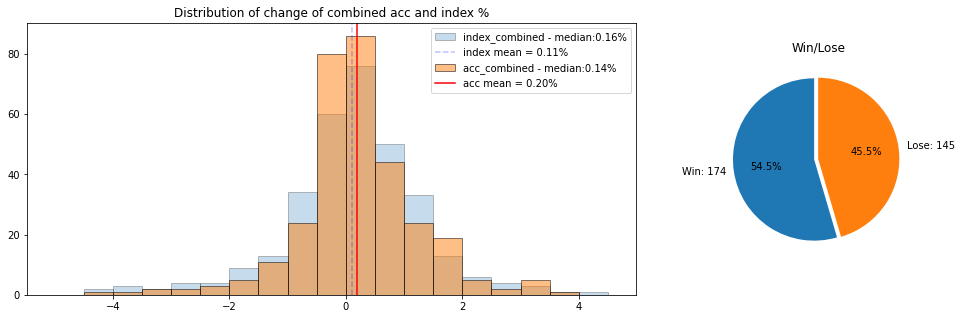

In [77]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{const.INDEX_COMBINED_NAME}_diff_p"] * 100
acc_diff_p_l = log_df[f"{const.ACC_COMBINED_NAME}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
index_combined_median = index_diff_p_l.median()
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=f"{const.INDEX_COMBINED_NAME} - median:{index_combined_median:.2f}%",
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# acc histogram
acc_combined_median = acc_diff_p_l.median()
ax1.hist(
    acc_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=f"{const.ACC_COMBINED_NAME} - median:{acc_combined_median:.2f}%",
)
acc_diff_p_mean = acc_diff_p_l.mean()  # type: ignore
ax1.axvline(
    acc_diff_p_mean,
    color="red",
    label="acc mean = %.2f%%" % acc_diff_p_mean,
)


ax1.set_title("Distribution of change of combined acc and index %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (acc_diff_p_l > index_diff_p_l).sum()
lose_num = (acc_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


## [Chart] Daily


In [78]:
# Filter 10 latest days
recent_daily_df = process_utils.filter_latest_x_rows(log_df, row_num= 10)


### Latest growth

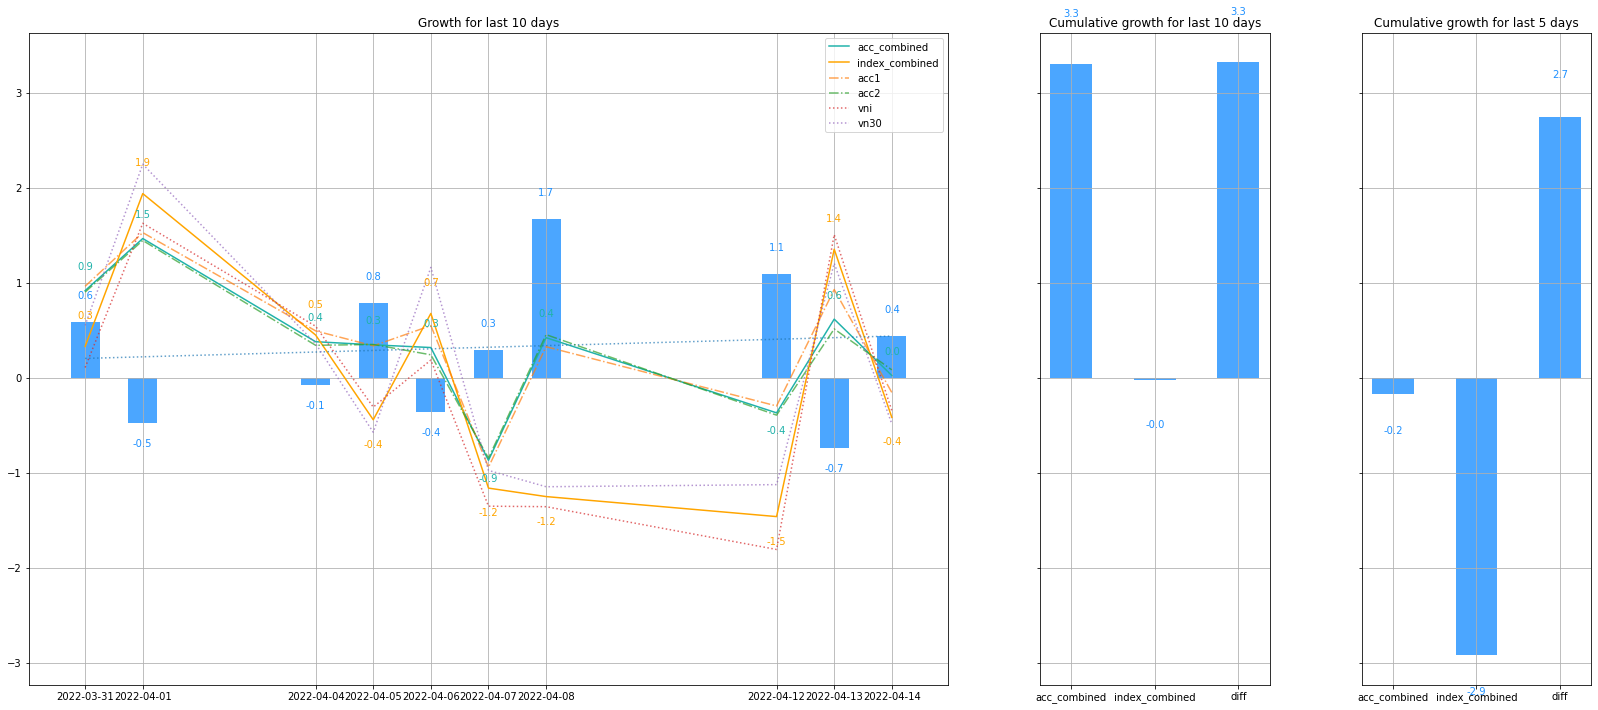

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(28, 12),
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [4, 1, 1]},
)  # type: ignore

# * Last x days line plot

for combined_name, color in zip(
    [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME], ["lightseagreen", "orange"]
):
    x = recent_daily_df.index
    y = recent_daily_df[f"{combined_name}_diff_p"] * 100
    ax1.plot_date(
        x,
        y,
        fmt="-",
        label=combined_name,
        color=color,
    )
    utils.add_labels(ax1, x, y, color=color)

recent_diff_df = (
    recent_daily_df[f"{const.ACC_COMBINED_NAME}_diff_p"]
    - recent_daily_df[f"{const.INDEX_COMBINED_NAME}_diff_p"]
) * 100

ax1.bar(
    recent_daily_df.index,
    recent_diff_df,
    width=0.5,
    alpha=0.8,
    color="dodgerblue",
)
utils.add_labels(ax1, recent_daily_df.index, recent_diff_df, color="dodgerblue")

# Trendline
first_date = recent_daily_df.index[0]
x = [(date - first_date).days for date in recent_daily_df.index]
utils.add_trend_line(ax1, ticks=recent_daily_df.index, x=x, y=recent_diff_df)


for single_name in const.ACC_NAME_L:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        fmt="-.",
        alpha=0.7,
        label=single_name,
    )

for single_name in const.INDEX_NAME_L:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        fmt=":",
        alpha=0.7,
        label=single_name,
    )


ax1.set_title("Growth for last 10 days")
ax1.set_xticks(ticks=recent_daily_df.index)
ax1.legend()
ax1.grid(True)


# * Cumulative growth bar plot
def _plot_cum_growth(df: pd.DataFrame, ax: plt.Axes, day_num: int) -> None:
    cum_acc_growth = (df[f"{const.ACC_COMBINED_NAME}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_index_growth = (df[f"{const.INDEX_COMBINED_NAME}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_diff_growth = cum_acc_growth - cum_index_growth
    x = [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME, "diff"]
    y = [cum_acc_growth, cum_index_growth, cum_diff_growth]
    ax.bar(
        x,
        y,
        width=0.5,
        alpha=0.8,
        color="dodgerblue",
    )
    ax.set_title(f"Cumulative growth for last {day_num} days")
    ax.grid(True)
    utils.add_labels(ax, x, y,color="dodgerblue")


_plot_cum_growth(recent_daily_df, ax2, 10)
# _plot_cum_growth(recent_daily_df.iloc[-5:], ax3, 5)
_plot_cum_growth(process_utils.filter_latest_x_rows(recent_daily_df, row_num= 5), ax3, 5)

plt.show()


In [80]:
# recent_daily_df  # type: ignore


### XIRR

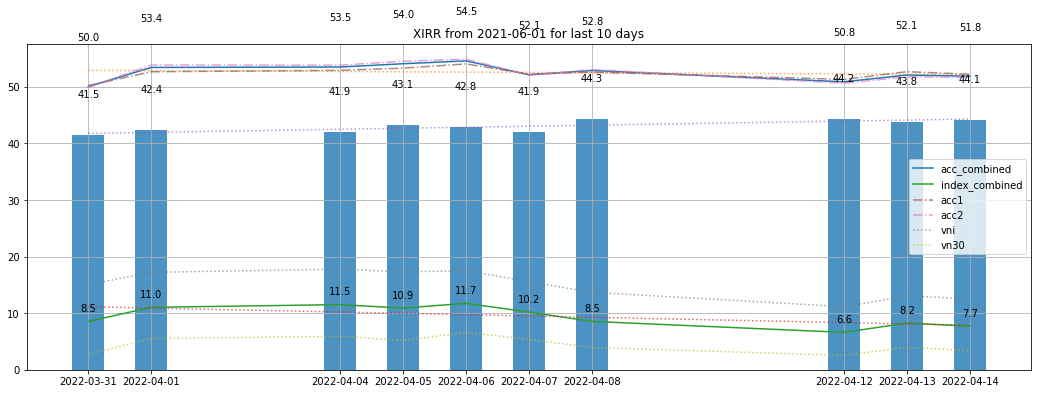

In [81]:
anchor_date = "2021-06-01"

xirr_data = {name: [] for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L}
for idx in recent_daily_df.index:
    for name in const.ALL_ACC_NAME_L:
        xirr_data[name].append(
            utils.calc_cashflow_xirr(
                cashflow_df=cf_df,
                log_df=log_df,
                anchor_date=anchor_date,
                date_idx=idx,
                col_name=name,
                user_name_combined_l=const.ALL_ACC_NAME_L,
            )
        )
    for idx_name in const.ALL_INDEX_NAME_L:
        xirr_data[idx_name].append(
            utils.calc_index_xirr(log_df, anchor_date, idx, idx_name)
        )
xirr_df = pd.DataFrame(xirr_data, index=recent_daily_df.index)


fig, ax1 = plt.subplots(figsize=(18, 6))  # type: ignore

# * Last x days line plot

for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[combined_name] * 100,  # type: ignore
        fmt="-",
        label=combined_name,
    )
    utils.add_labels(ax1, xirr_df.index, xirr_df[combined_name] * 100)  # type: ignore

    # Trendline
    first_date = xirr_df.index[0]
    x = [(date - first_date).days for date in xirr_df.index]
    utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=xirr_df[combined_name] * 100)  # type: ignore

recent_diff = (xirr_df[const.ACC_COMBINED_NAME] - xirr_df[const.INDEX_COMBINED_NAME]) * 100  # type: ignore

ax1.bar(
    xirr_df.index,
    recent_diff,
    width=0.5,
    alpha=0.8,
)
utils.add_labels(ax1, xirr_df.index, recent_diff)  # type: ignore

# Trendline
first_date = xirr_df.index[0]
x = [(date - first_date).days for date in xirr_df.index]
utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=recent_diff)  # type: ignore


for single_name in const.ACC_NAME_L:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        fmt="-.",
        alpha=0.7,
        label=single_name,
    )

for single_name in const.INDEX_NAME_L:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        fmt=":",
        alpha=0.7,
        label=single_name,
    )


ax1.set_title(f"XIRR from {anchor_date} for last 10 days")
ax1.set_xticks(ticks=xirr_df.index)
ax1.legend()
ax1.grid(True)

plt.show()


In [82]:
# xirr_df  # type: ignore


### Income

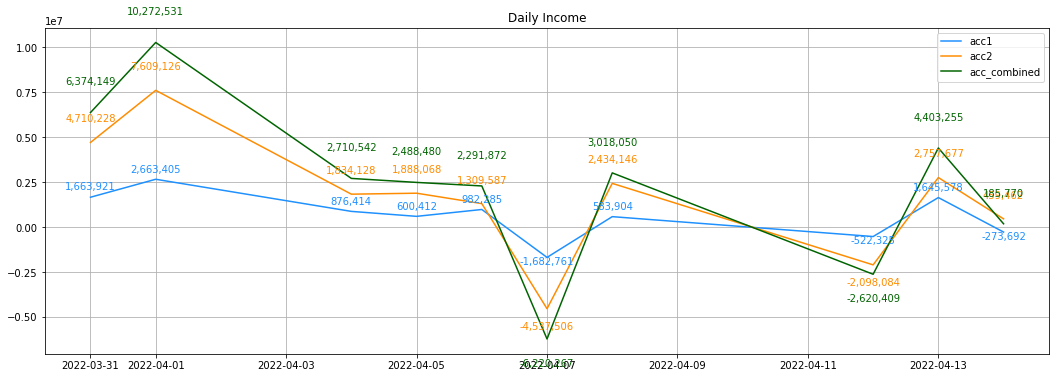

In [83]:
fig, ax = plt.subplots(figsize=(18, 6))  # type: ignore

for name, color in zip(const.ALL_ACC_NAME_L, ["dodgerblue", "darkorange", "darkgreen"]):
    income_l = recent_daily_df[f"{name}_diff"]
    ax.plot_date(
        recent_daily_df.index,
        income_l,  # type: ignore
        fmt="-",
        label=name,
        color=color,
    )

    label_l = [f"{income:,.0f}" for income in income_l]
    utils.add_labels(ax, recent_daily_df.index, income_l,label_l=label_l, color=color)  # type: ignore

ax.set_title("Daily Income")
ax.grid(True)
ax.legend()

plt.show()


In [84]:
# recent_daily_df  # type: ignore


### Growth time series


In [85]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df:pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L:
        # set first date aux_diff_p to 1
        filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
        # calculate growth using cumulative product since anchor date
        
        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)
        
    for name in const.ALL_ACC_NAME_L:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date,
                date_idx,
                name,
                const.ALL_ACC_NAME_L,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
        
    for name in const.ALL_INDEX_NAME_L:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_index_xirr(
                log_df,
                anchor_date,
                date_idx,
                name,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
    
    return df


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_89811/3190605186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_89811/3190605186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_89811/3190605186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

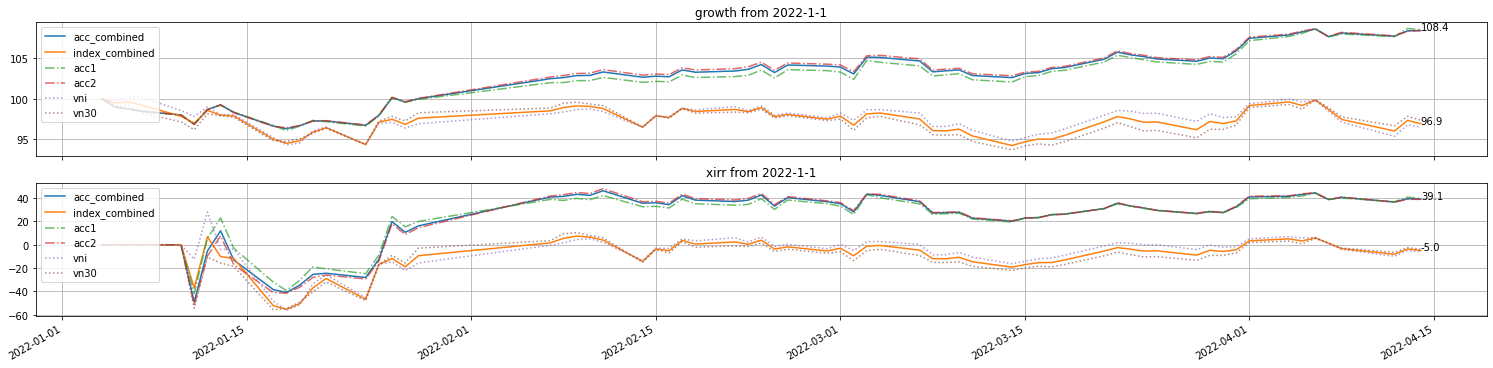

In [86]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2022-1-1"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, type: str):

    for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            fmt="-",
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in const.ACC_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt="-.",
            alpha=0.7,
            label=single_name,
        )

    for single_name in const.INDEX_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt=":",
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()
    
_plot_overall_growth_xirr(ax1, "growth")
_plot_overall_growth_xirr(ax2, "xirr")

plt.show()


In [87]:
# growth_xirr_df  # type: ignore


## [Process] Add period info


In [88]:
log_df = process_utils.add_period_cols(log_df)
# log_df.tail()


## [Chart] Weekly

In [89]:
weekly_df = process_utils.get_period_df(
    period_symbol="W",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Not enough space to plot every week
weekly_df = process_utils.filter_latest_x_rows(df=weekly_df, row_num=20)  # type: ignore


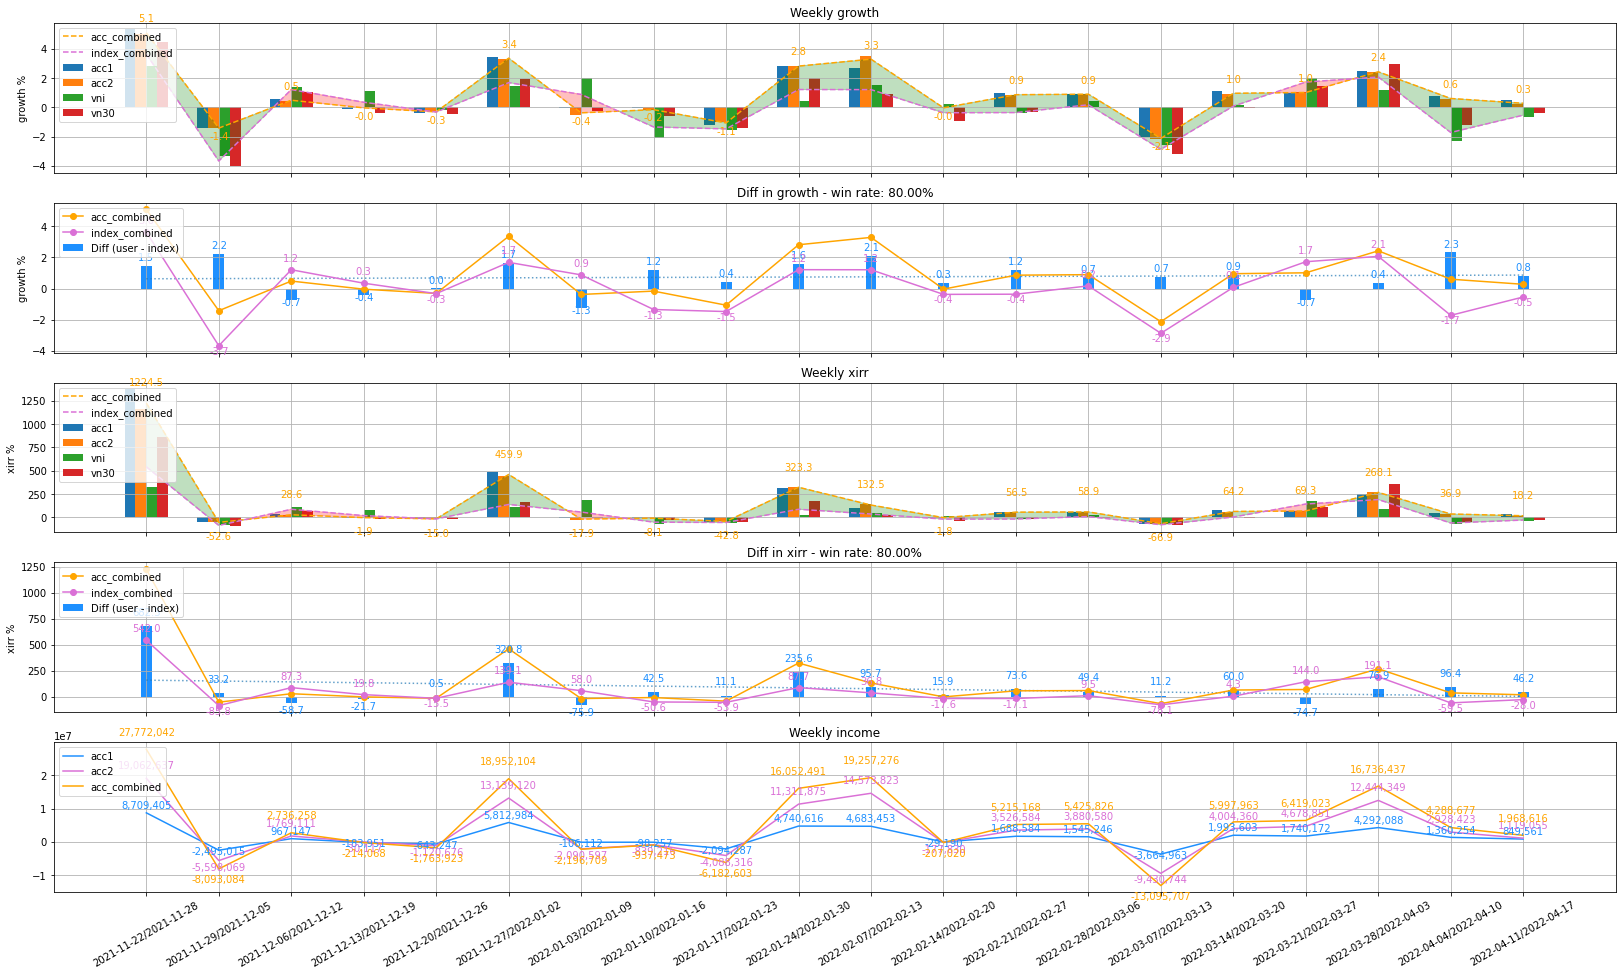

In [90]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=weekly_df,
    period_name="Weekly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [91]:
# weekly_df.tail()

## [Chart] Monthly


In [92]:
monthly_df = process_utils.get_period_df(
    period_symbol="M",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)

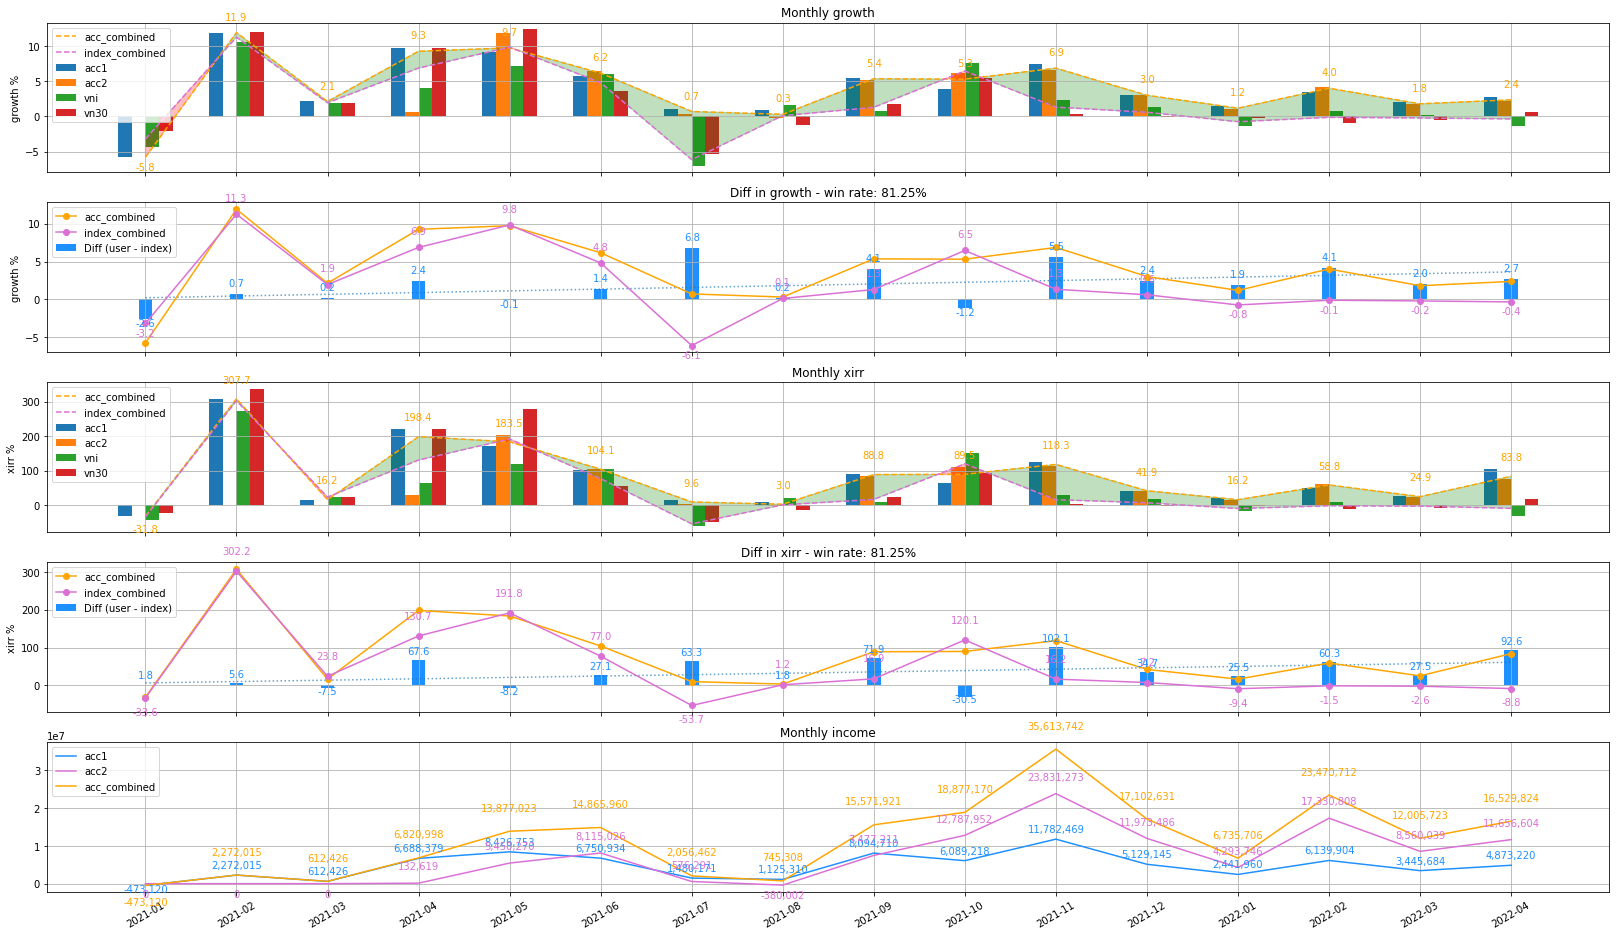

In [93]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=monthly_df,
    period_name="Monthly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [94]:
# monthly_df # type: ignore

## Quaterly


In [95]:
quaterly_df = process_utils.get_period_df(
    period_symbol="Q",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020Q4
quaterly_df.drop(["2020Q4"], inplace=True)

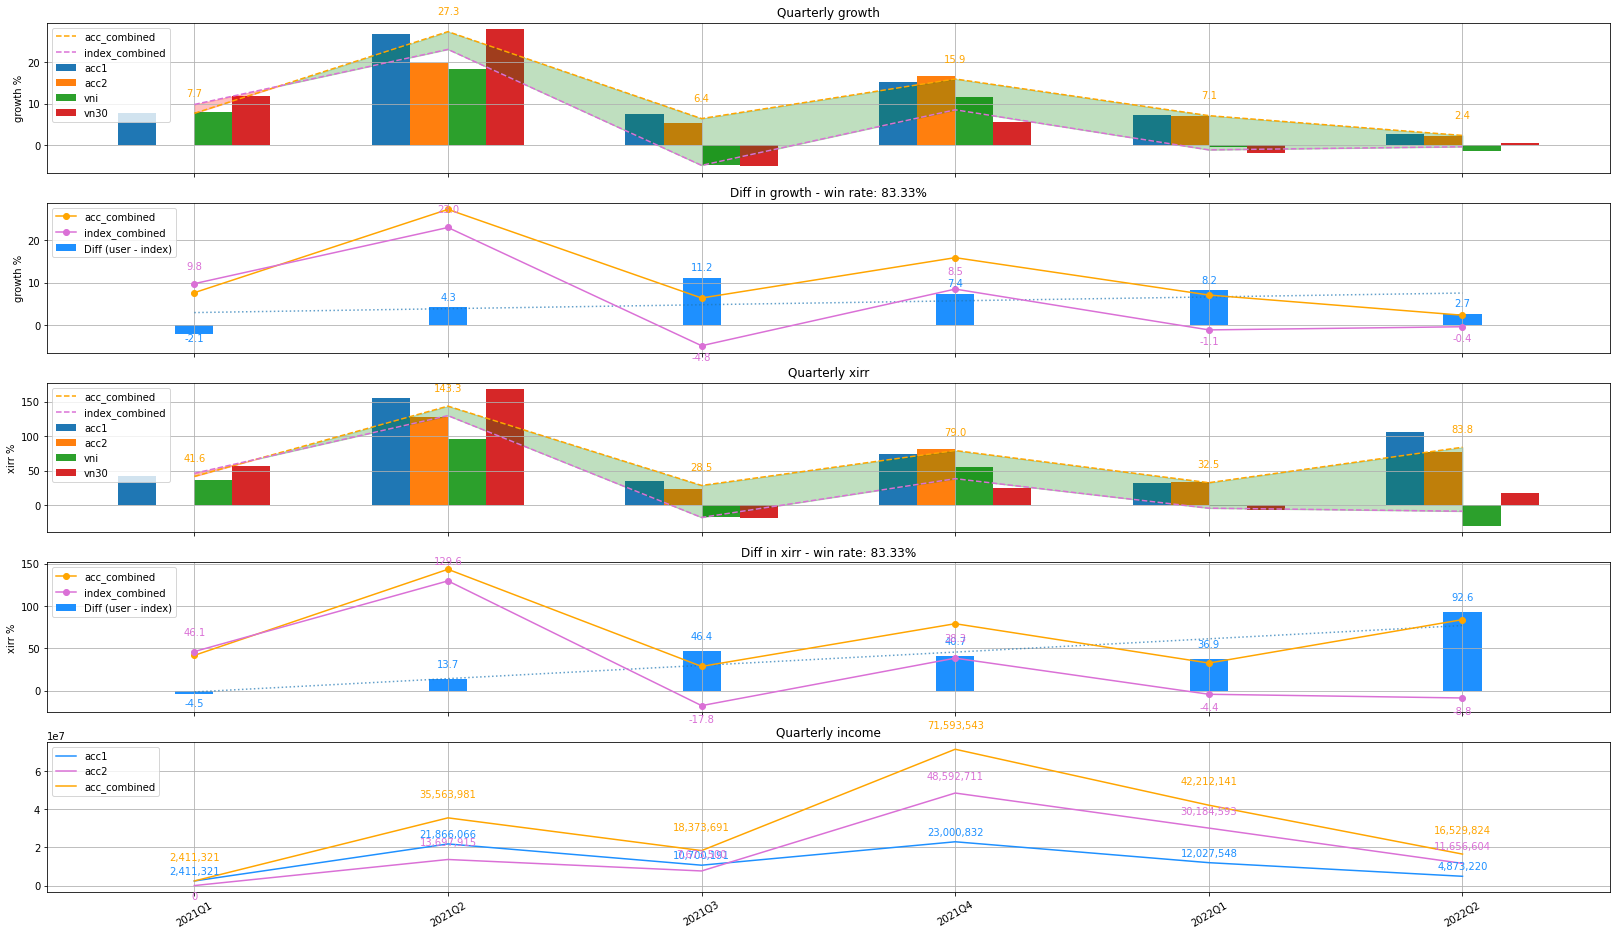

In [96]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=quaterly_df,
    period_name="Quarterly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [97]:
# quaterly_df  # type: ignore


## Yearly

In [98]:
yearly_df = process_utils.get_period_df(
    period_symbol="Y",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020
yearly_df.drop(["2020"], inplace=True)

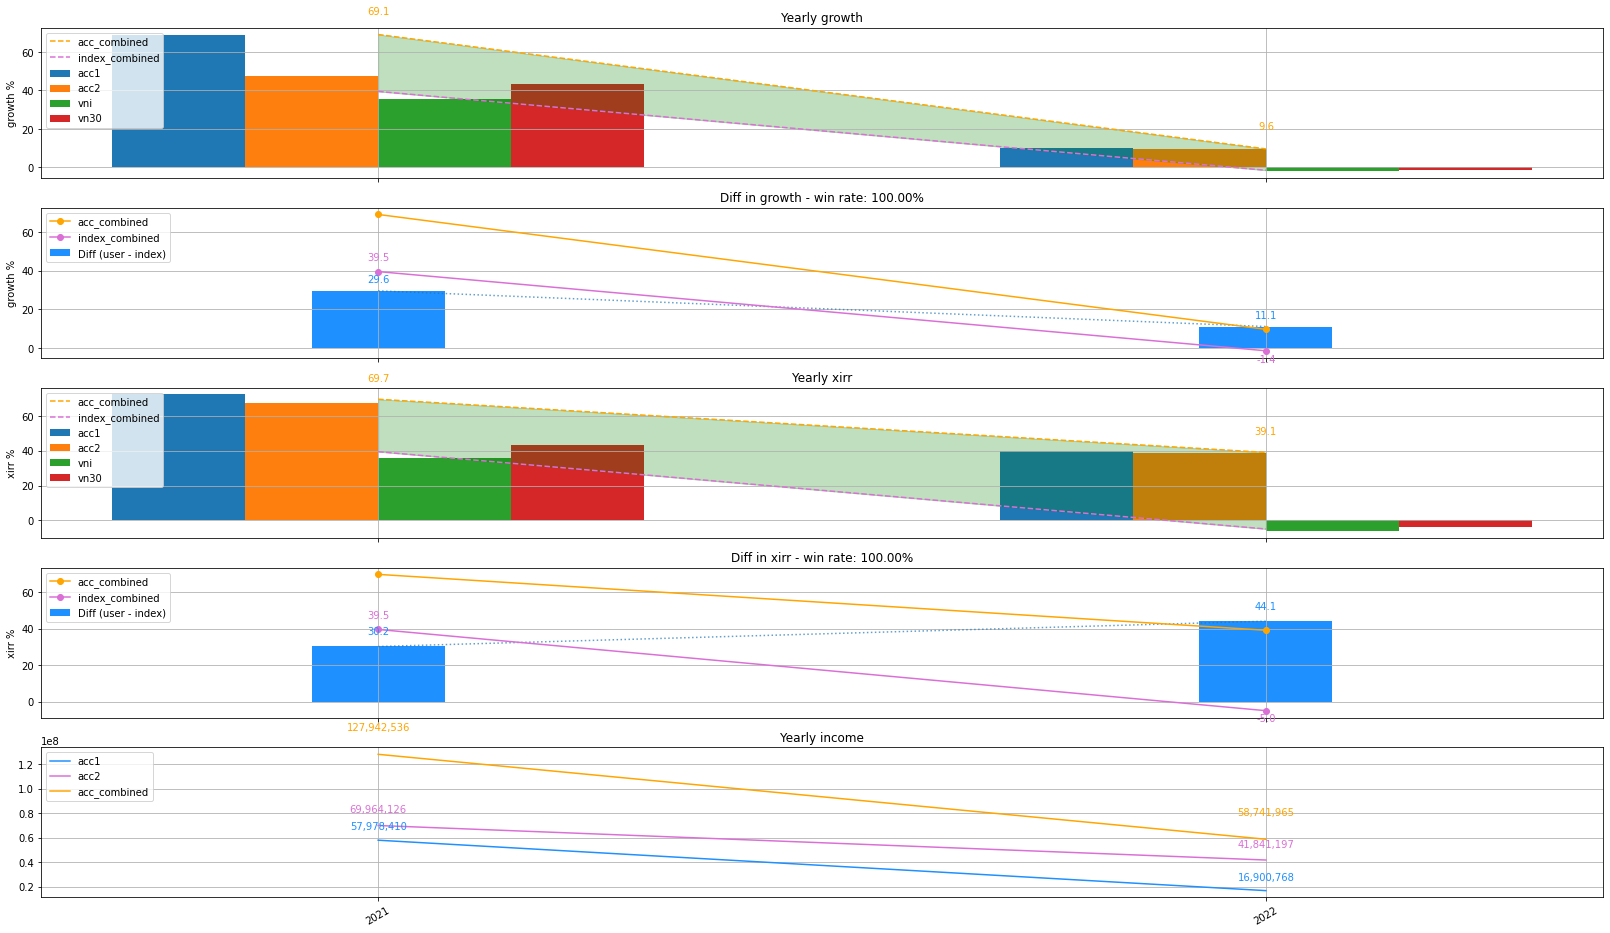

In [99]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=yearly_df,
    period_name="Yearly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)